In [10]:
# 1. Import libraries
from whitebox.whitebox_tools import WhiteboxTools
from rasterio.mask import mask

import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
from matplotlib import cm
from matplotlib.colors import Normalize
from PIL import Image
import os

In [4]:
# 2. Set up WhiteboxTools
wbt = WhiteboxTools()
work_dir = "/Users/martinpalkovic/Documents/Documents_icloud/gis_projects/SevenMileLake/twi_analysis"  # 🔁 Replace this with your actual folder path
os.chdir(work_dir)
wbt.work_dir = work_dir

# File names
dem_file = "sml_dem.tif"  # 🔁 Replace with your DEM file
filled = "filled.tif"
slope = "slope.tif"
slope_rad = "slope_rad.tif"
flow_acc = "flow_acc.tif"
twi = "twi.tif"

In [5]:
# 3. Run TWI analysis using WhiteboxTools
wbt.fill_depressions(dem_file, filled)
wbt.slope(filled, slope_rad, units="radians")
wbt.d8_flow_accumulation(filled, flow_acc, out_type="cells")
wbt.wetness_index(flow_acc, slope_rad, twi)

./whitebox_tools --run="FillDepressions" --wd="/Users/martinpalkovic/Documents/Documents_icloud/gis_projects/SevenMileLake/twi_analysis" --dem='sml_dem.tif' --output='filled.tif' --fix_flats -v --compress_rasters=False

******************************
* Welcome to FillDepressions *
* Powered by WhiteboxTools   *
* www.whiteboxgeo.com        *
******************************
Reading data...
Finding pit cells: 12%
Finding pit cells: 25%
Finding pit cells: 37%
Finding pit cells: 50%
Finding pit cells: 62%
Finding pit cells: 75%
Finding pit cells: 87%
Finding pit cells: 100%
Filling depressions: 0%
Filling depressions: 1%
Filling depressions: 2%
Filling depressions: 3%
Filling depressions: 4%
Filling depressions: 5%
Filling depressions: 6%
Filling depressions: 7%
Filling depressions: 8%
Filling depressions: 9%
Filling depressions: 10%
Filling depressions: 11%
Filling depressions: 12%
Filling depressions: 13%
Filling depressions: 14%
Filling depressions: 15%
Filling depressions: 16%
Filling d

0

✅ Reclassified TWI written to: /Users/martinpalkovic/Documents/Documents_icloud/gis_projects/SevenMileLake/twi_analysis/wet_zones.tif


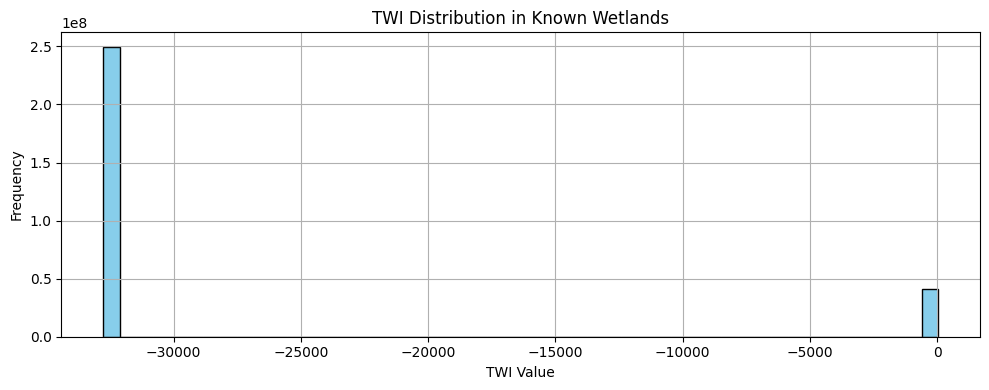

In [11]:
# File paths from previous steps
slope_path = slope         # "slope.tif"
twi_path = twi             # "twi.tif"
wetlands_path = "wetlands.geojson"  # Optional; replace with .shp if needed
wet_zone_path = os.path.join(work_dir, "wet_zones.tif")

# Load slope raster
with rasterio.open(slope_path) as slope_src:
    slope_arr = slope_src.read(1)
    slope_meta = slope_src.meta.copy()

# Mask out low slopes (<2°)
slope_mask = slope_arr >= 2.0

# Load TWI raster
with rasterio.open(twi_path) as twi_src:
    twi_arr = twi_src.read(1)
    twi_meta = twi_src.meta.copy()
    nodata_val = twi_src.nodata
    twi_arr = np.where(twi_arr == nodata_val, np.nan, twi_arr)

# Apply slope mask to TWI
twi_masked = np.where(slope_mask, twi_arr, np.nan)

# Reclassify TWI into 5 quantile-based wetness zones
quantiles = np.nanpercentile(twi_masked, [20, 40, 60, 80])
wetness_classes = np.digitize(twi_masked, quantiles)

# Save as new raster
wet_meta = twi_meta
wet_meta.update({'dtype': 'uint8', 'nodata': 0})

with rasterio.open(wet_zone_path, 'w', **wet_meta) as dst:
    dst.write(np.nan_to_num(wetness_classes, nan=0).astype(np.uint8), 1)

print("✅ Reclassified TWI written to:", wet_zone_path)

# Optional: Compare with known wetlands
try:
    wetlands = gpd.read_file(wetlands_path).to_crs(twi_meta["crs"])

    with rasterio.open(twi_path) as src:
        twi_in_wetlands, _ = mask(src, wetlands.geometry, crop=True)
    
    plt.figure(figsize=(10, 4))
    plt.hist(twi_in_wetlands[0].flatten(), bins=50, color="skyblue", edgecolor="black")
    plt.title("TWI Distribution in Known Wetlands")
    plt.xlabel("TWI Value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print("⚠️ Skipped wetlands comparison:", e)